# 4.4 画像生成のファインチューニング（学習コード）

本Notebookでは、数枚の画像を用いて画像生成AIをファインチューニングするコードを記載します。  
画像生成AIモデルの推論については、「4-2_StableDiffusion.ipynb」をご覧ください。

## 事前準備

学習環境の整備やデータセットの準備を実施します。

### (1) 環境設定

`huggingface/diffusers`リポジトリをクローンし、学習環境を整備します。

In [ ]:
!git clone https://github.com/huggingface/diffusers -b v0.25.0 --depth 1
%cd diffusers
!pip install -e .

%cd examples/dreambooth
!pip install -r requirements_sdxl.txt

!pip install bitsandbytes==0.42.0
!pip install transformers==4.35.2
!pip install accelerate==0.26.1
!pip install peft==0.7.0

Cloning into 'diffusers'...
remote: Enumerating objects: 1302, done.
remote: Counting objects: 100% (1302/1302), done.
remote: Compressing objects: 100% (1080/1080), done.
remote: Total 1302 (delta 427), reused 529 (delta 204), pack-reused 0 (from 0)
Receiving objects: 100% (1302/1302), 3.28 MiB | 12.74 MiB/s, done.
Resolving deltas: 100% (427/427), done.
Note: switching to '7f551e29ff4ad05615cb38530a8940811f9e5936'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

/content/diffusers
Obtaining file:///content/diffusers
  Insta

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

### (2) データセットの準備

データセットを取得します。  

※ 書籍には記載されていませんが、`.huggingface`ディレクトリが同時にダウンロードされエラーになる場合があるため、画像のダウンロード後に`.huggingface`ディレクトリを削除します。

In [ ]:
import os
import shutil
from huggingface_hub import snapshot_download


local_dir = "./image"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

# 不要なディレクトリを削除する
huggingface_dir = os.path.join(local_dir, ".huggingface")
if os.path.exists(huggingface_dir):
    shutil.rmtree(huggingface_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

alvan-nee-bQaAJCbNq3g-unsplash.jpeg:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

alvan-nee-Id1DBHv4fbg-unsplash.jpeg:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

alvan-nee-eoqnr8ikwFE-unsplash.jpeg:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

alvan-nee-brFsZ7qszSY-unsplash.jpeg:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

alvan-nee-9M0tSjb-cpA-unsplash.jpeg:   0%|          | 0.00/677k [00:00<?, ?B/s]

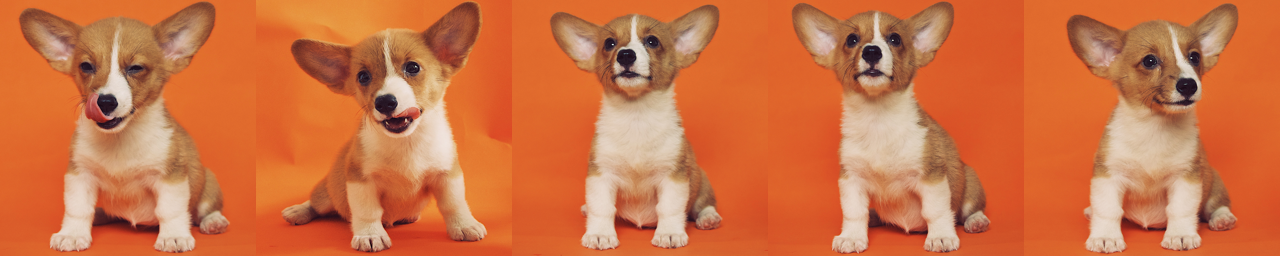

In [ ]:
import os
import glob
from PIL import Image


def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

img_paths = "./image/*.jpeg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Appendix) イメージアップロード

オリジナルのイメージをアップロードして試してみてください。  
サンプルイメージを使用する場合は、以下のコードブロックを実行しないでください。

In [ ]:
import os
import glob
from google.colab import files
import shutil


upload_folder = "./image"
if os.path.isdir(upload_folder):
  shutil.rmtree(upload_folder)
os.mkdir(upload_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

## ファインチューニングの実装

### (1) 学習実行

In [ ]:
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="./image" \
  --output_dir="my_LoRA" \
  --mixed_precision="fp16" \
  --instance_prompt="a photo of sks dog" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --learning_rate=1e-5 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --use_8bit_adam \
  --max_train_steps=500 \
  --seed="0"

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_no